In [0]:
!pip install gensim

In [0]:
# import dependecies
import multiprocessing
import os, json, requests
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [12]:
# Download NLTK tokenizer models (only the first time)
nltk.download("punkt")
nltk.download("stopwords")

# function to convert words to list
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()    
    return list(map(lambda x:x.lower(),words))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Loads training text from Gutenberg website

In [0]:
# Article on earth from Gutenberg website
filepath_1 = "http://www.gutenberg.org/files/33224/33224-0.txt"
# a tale of two cities
filepath_2 = "http://www.gutenberg.org/files/98/98-0.txt"

corpus_raw_1 = requests.get(filepath_1).text
corpus_raw_2 = requests.get(filepath_2).text

corpus_raw = corpus_raw_1 + corpus_raw_2

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

#sentence where each word is tokenized
sentences = []

for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))


#Loads training text from txt files

In [45]:
file = "training/about_cancer.txt"
file2 = "training/programming_languages.txt"

# change file to file2 to train on the second dataset
f = open(file, "r")
corpus_raw = f.read()
f.close()

print(len(corpus_raw))

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

#sentence where each word is tokenized
sentences = []

for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))


1152131


In [46]:
num_features = 300

# Minimum word count threshold
#min_word_count = 3
min_word_count = 2

# Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
print("Number of workers", num_workers)

# Context window length
context_size = 7

# Downsampling setting for frequent words. 0 - 1e-5 is good for this downsampling
downsampling = 1e-3

seed = 1

model2vec = w2v.Word2Vec(
            sg=1,
            seed=seed,
            workers=num_workers,
            size=num_features,
            min_count=min_word_count,
            window=context_size,
            sample=downsampling
        )

model2vec.build_vocab(sentences)
print(model2vec.corpus_count)

Number of workers 2
7925


In [0]:
# Start training
model2vec.train(sentences, total_examples=model2vec.corpus_count, epochs=100)

# save to file
if not os.path.exists("trained"):
    os.makedirs("trained")
    
#model2vec.save(os.path.join("trained","about_cancer.w2v"))
model2vec.save(os.path.join("trained","programming_languages.w2v"))

#Function to format output from model

In [0]:
def format_output(items, similar_to):
  print("Words associated with", similar_to)
  for l in items:
    print('"{}" ---> {:}'.format(l[0], l[1]))
  print("\n" * 3)

#Find related or assoiated words

In [57]:
#word_list = ["cancer", "malignant", "tumor", "cell"]
word_list = ["computer", "languages", "bytecode", "machine"]

word = word_list[2]
result = model2vec.wv.most_similar(word)
format_output(result, word)

Words associated with bytecode
"dalvik" ---> 0.4510611593723297
"aot" ---> 0.4445607662200928
"jazelle" ---> 0.4176190495491028
"categorizations" ---> 0.41350990533828735
"classpath" ---> 0.4025055766105652
"jvm" ---> 0.38669323921203613
"icedtea" ---> 0.3858563303947449
"blur" ---> 0.3680500090122223
"jit" ---> 0.35728979110717773
"secure" ---> 0.34573984146118164






/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# for word2vec model trained on wikipedia cancer content
#model2vec.wv.most_similar_cosmul(positive=['tumors', 'cancer'], negative=['cell'])

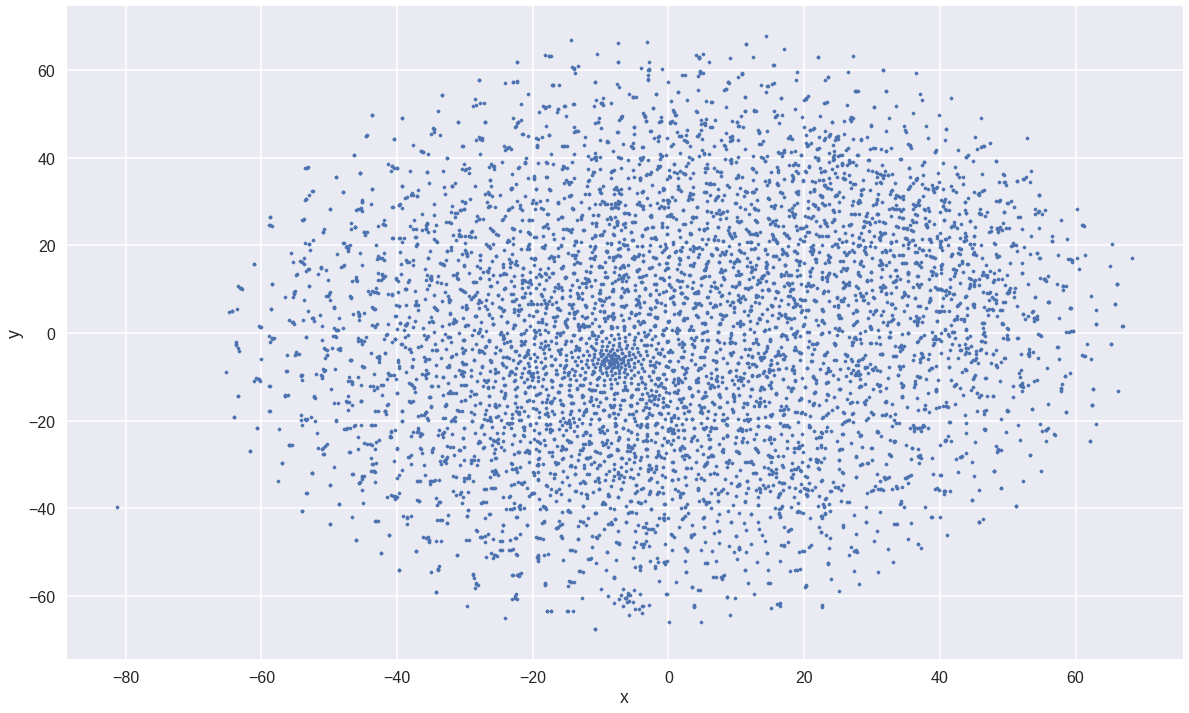

In [59]:
# plot word cluster
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = model2vec.wv.vectors
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model2vec.wv.vocab[word].index])
            for word in model2vec.wv.vocab
        ]
    ],    
    columns=["word", "x", "y"]
)
sns.set_context("poster")
ax = points.plot.scatter("x", "y", s=10, figsize=(20, 12))
fig = ax.get_figure()
